In [582]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import plotly.express as px

# modelling
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, calinski_harabasz_score, silhouette_samples, davies_bouldin_score
from sklearn.decomposition import PCA

# import a bunch of clustering models
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

In [583]:
df = pd.read_csv('Use this dataset/uswtdb_v5_0_20220427_rename.csv',
                 index_col=False)

/var/folders/nv/vxq64h_j3ydccspj69p0_4_c0000gn/T/ipykernel_44048/2769116822.py:1: DtypeWarning:

Columns (1,2,3,4,6,7,8,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90) have mixed types. Specify dtype option on import or set low_memory=False.



In [584]:
df.shape

(71784, 124)

In [585]:
df.head()

,Plant Id,Combined Heat And\nPower Plant,Nuclear Unit Id,Plant Name,Operator Name,Operator Id,Plant State,Census Region,NERC Region,Reserved,NAICS Code,EIA Sector Number,Sector Name,Reported\nPrime Mover,Reported\nFuel Type Code,AER\nFuel Type Code,Balancing\nAuthority Code,Respondent\nFrequency,Physical\nUnit Label,Quantity\nJanuary,Quantity\nFebruary,Quantity\nMarch,Quantity\nApril,Quantity\nMay,Quantity\nJune,Quantity\nJuly,Quantity\nAugust,Quantity\nSeptember,Quantity\nOctober,Quantity\nNovember,Quantity\nDecember,Elec_Quantity\nJanuary,Elec_Quantity\nFebruary,Elec_Quantity\nMarch,Elec_Quantity\nApril,Elec_Quantity\nMay,Elec_Quantity\nJune,Elec_Quantity\nJuly,Elec_Quantity\nAugust,Elec_Quantity\nSeptember,Elec_Quantity\nOctober,Elec_Quantity\nNovember,Elec_Quantity\nDecember,MMBtuPer_Unit\nJanuary,MMBtuPer_Unit\nFebruary,MMBtuPer_Unit\nMarch,MMBtuPer_Unit\nApril,MMBtuPer_Unit\nMay,MMBtuPer_Unit\nJune,MMBtuPer_Unit\nJuly,MMBtuPer_Unit\nAugust,MMBtuPer_Unit\nSeptember,MMBtuPer_Unit\nOctober,MMBtuPer_Unit\nNovember,MMBtuPer_Unit\nDecember,Tot_MMBtu\nJanuary,Tot_MMBtu\nFebruary,Tot_MMBtu\nMarch,Tot_MMBtu\nApril,Tot_MMBtu\nMay,Tot_MMBtu\nJune,Tot_MMBtu\nJuly,Tot_MMBtu\nAugust,Tot_MMBtu\nSeptember,Tot_MMBtu\nOctober,Tot_MMBtu\nNovember,Tot_MMBtu\nDecember,Elec_MMBtu\nJanuary,Elec_MMBtu\nFebruary,Elec_MMBtu\nMarch,Elec_MMBtu\nApril,Elec_MMBtu\nMay,Elec_MMBtu\nJune,Elec_MMBtu\nJuly,Elec_MMBtu\nAugust,Elec_MMBtu\nSeptember,Elec_MMBtu\nOctober,Elec_MMBtu\nNovember,Elec_MMBtu\nDecember,Netgen\nJanuary,Netgen\nFebruary,Netgen\nMarch,Netgen\nApril,Netgen\nMay,Netgen\nJune,Netgen\nJuly,Netgen\nAugust,Netgen\nSeptember,Netgen\nOctober,Netgen\nNovember,Netgen\nDecember,Total Fuel Consumption\nQuantity,Electric Fuel Consumption\nQuantity,Total Fuel Consumption\nMMBtu,Elec Fuel Consumption\nMMBtu,Net Generation\n(Megawatthours),YEAR,case_id,faa_digital_obstacle_id,faa_obstruction_evaluation_id,usgs_id,eia_id,state,county,state_county_id,project_name,operational_year,project_turbine_num,cumulative_capacity (MW),manufacturer,model_name,turbine_capacity (KW),hub_height (m),rotor_diameter (m),rotor_swept area (m2),max_height (m),retrofit (y/n),retrofit_year,attribute_confidence_level (1/2/3),location_confidence_level (1/2/3),location_verification_date,image_source,xlong,ylat
0,1.00,N,.,Sand Point,"TDX Sand Point Generating, LLC",63560.00,AK,PACN,NaN,NaN,22.00,1.00,Electric Utility,WT,WND,WND,NaN,A,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,103,78,97,77,91,94,111,113,115,117,66,122,103,78,97,77,91,94,111,113,115,117,66,122,11.609,8.836,11.011,8.745,10.329,10.673,12.572,12.738,13.05,13.18,7.49,13.76,0.00,0.00,1184.00,1184.00,134.00,2021.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,90.00,N,.,Snake River,Nome Joint Utility Systems,13642.00,AK,PACN,NaN,NaN,22.00,1.00,Electric Utility,WT,WND,WND,NaN,A,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1632,1242,1548,1229,1452,1500,1767,1791,1835,1853,1053,1935,1632,1242,1548,1229,1452,1500,1767,1791,1835,1853,1053,1935,184.495,140.449,175.033,139.011,164.189,169.653,199.846,202.478,207.46,209.54,119.06,218.79,0.00,0.00,18837.00,18837.00,2130.00,2021.00,3032513.00,02-020068,2009-WTW-1520-OE,1900.00,90.00,AK,Nome Census Area,2180.00,Nome,2008.00,18.00,0.90,Entegrity,EW50,50.00,31.10,15.00,176.71,38.60,0.00,NaN,3.00,3.00,9/30/2019,Digital Globe,-165.43,64.57
2,90.00,N,.,Snake River,Nome Joint Utility Systems,13642.00,AK,PACN,NaN,NaN,22.00,1.00,Electric Utility,WT,WND,WND,NaN,A,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1632,1242,1548,1229,1452,1500,1767,1791,1835,1853,1053,1935,1632,1242,1548,1229,1452,1500,1767,1791,1835,1853,1053,1935,184.495,140.449,175.033,139.011,164.189,169.653,199.846,202.478,207.46,209.54,119.06,218.79,0.00,0.00,18837.00,18837.00,2130.00,2021.00,3032511.00,02-020066,2009-WTW-1518-OE,1898.00,90.00,AK,Nome Census Area,2180.0

## Missing Model Specs 

In [586]:
df.isnull().sum()

Plant Id                                7794
Combined Heat And\nPower Plant          7794
Nuclear Unit Id                         7794
Plant Name                              7794
Operator Name                           7794
Operator Id                             7794
Plant State                             7794
Census Region                           7794
NERC Region                             7973
Reserved                               71784
NAICS Code                              7794
EIA Sector Number                       7794
Sector Name                             7794
Reported\nPrime Mover                   7794
Reported\nFuel Type Code                7794
AER\nFuel Type Code                     7794
Balancing\nAuthority Code               7965
Respondent\nFrequency                   7796
Physical\nUnit Label                   71784
Quantity\nJanuary                       7794
Quantity\nFebruary                      7794
Quantity\nMarch                         7794
Quantity\n

In [587]:
unique_projects = df['project_name'].nunique()
print(f'we have {unique_projects} unique projects before removing null values')

we have 1726 unique projects before removing null values


### Missing Generation Data

In [588]:
# remove 0 values for net generation because they are probably not operational
missing_values = df[df['Net Generation\n(Megawatthours)'] == 0]['project_name'].nunique()
print(missing_values)

0


In [589]:
print(f'we are dropping {(missing_values/unique_projects)*100:.2f}% of the data')
df = df[df['Net Generation\n(Megawatthours)'] != 0]
unique_projects = df['project_name'].nunique()
print(f'we have {unique_projects} unique projects after removing null values')

we are dropping 0.00% of the data
we have 1726 unique projects after removing null values


### Missing Model Names

In [590]:
missing_values = df[df.model_name.isnull()]['project_name'].nunique()
print(missing_values)

213


In [591]:
print(f'we are dropping {(missing_values/unique_projects)*100:.2f}% of the data')
df = df[~df.model_name.isnull()]
unique_projects = df['project_name'].nunique()
print(f'we have {unique_projects} unique projects after removing null values')

we are dropping 12.34% of the data
we have 1519 unique projects after removing null values


### Turbine Capacity

In [592]:
missing_values=df[df['turbine_capacity (KW)'].isnull()]['project_name'].nunique()
print(missing_values)

2


In [593]:
print(f'we are dropping {(missing_values/unique_projects)*100:.2f}% of the data')
df = df[~df['turbine_capacity (KW)'].isnull()]
unique_projects = df['project_name'].nunique()
print(f'we have {unique_projects} unique projects after removing null values')

we are dropping 0.13% of the data
we have 1518 unique projects after removing null values


## Model

In [594]:
# check that there are no missing values
missing_values=df[df['project_turbine_num'].isnull()]['project_name'].nunique()
print(missing_values)

0


In [595]:
# are the columns the same?
a = df['Elec Fuel Consumption\nMMBtu'] == df['Total Fuel Consumption\nMMBtu']
# assert all of the a.value_counts() are true
assert all(a.value_counts())==True, 'The columns are not the same'

In [596]:
df.isnull().sum()

Plant Id                                4078
Combined Heat And\nPower Plant          4078
Nuclear Unit Id                         4078
Plant Name                              4078
Operator Name                           4078
Operator Id                             4078
Plant State                             4078
Census Region                           4078
NERC Region                             4248
Reserved                               67034
NAICS Code                              4078
EIA Sector Number                       4078
Sector Name                             4078
Reported\nPrime Mover                   4078
Reported\nFuel Type Code                4078
AER\nFuel Type Code                     4078
Balancing\nAuthority Code               4248
Respondent\nFrequency                   4078
Physical\nUnit Label                   67034
Quantity\nJanuary                       4078
Quantity\nFebruary                      4078
Quantity\nMarch                         4078
Quantity\n

In [597]:
features = ['eia_id',
            'turbine_capacity (KW)',
            'hub_height (m)',
            'rotor_diameter (m)',
            'rotor_swept area (m2)',
            'max_height (m)',
            'xlong','ylat']

In [598]:
# group by turbine_capacity (KW) and project_name
model_df = df[features]

In [599]:
model_df.shape

(67034, 8)

In [600]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67034 entries, 1 to 71783
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   eia_id                 64484 non-null  float64
 1   turbine_capacity (KW)  67034 non-null  float64
 2   hub_height (m)         66508 non-null  float64
 3   rotor_diameter (m)     66753 non-null  float64
 4   rotor_swept area (m2)  66753 non-null  float64
 5   max_height (m)         66508 non-null  float64
 6   xlong                  67034 non-null  float64
 7   ylat                   67034 non-null  float64
dtypes: float64(8)
memory usage: 4.6 MB


In [601]:
# drop all null values
model_df = model_df.dropna()

In [602]:
len(model_df)

64007

## Numerical Features

In [603]:
model_df.describe()

,eia_id,turbine_capacity (KW),hub_height (m),rotor_diameter (m),rotor_swept area (m2),max_height (m),xlong,ylat
count,64007.00,64007.00,64007.00,64007.00,64007.00,64007.00,64007.00,64007.00
mean,58378.11,1992.28,81.37,96.41,7690.68,129.60,-99.36,38.59
std,4200.89,681.80,11.39,22.32,3248.14,21.15,10.68,5.49
min,90.00,50.00,22.80,15.00,176.71,30.40,-170.50,17.97
25%,56780.50,1500.00,80.00,82.00,5281.02,121.00,-102.34,34.15
50%,57834.00,2000.00,80.00,100.00,7853.98,130.10,-99.02,39.36
75%,60414.00,2300.00,87.50,112.00,9852.03,145.10,-94.89,43.01
max,65270.00,6000.00,131.00,155.00,18869.19,199.60,-65.61,66.84


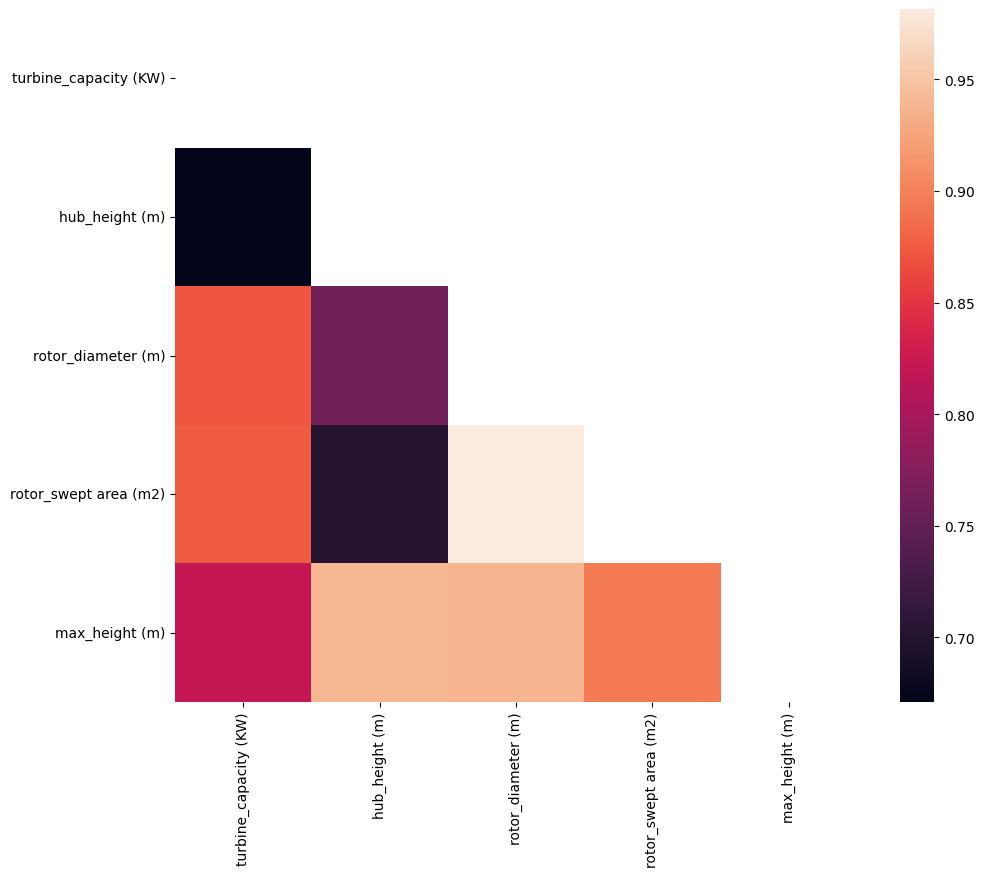

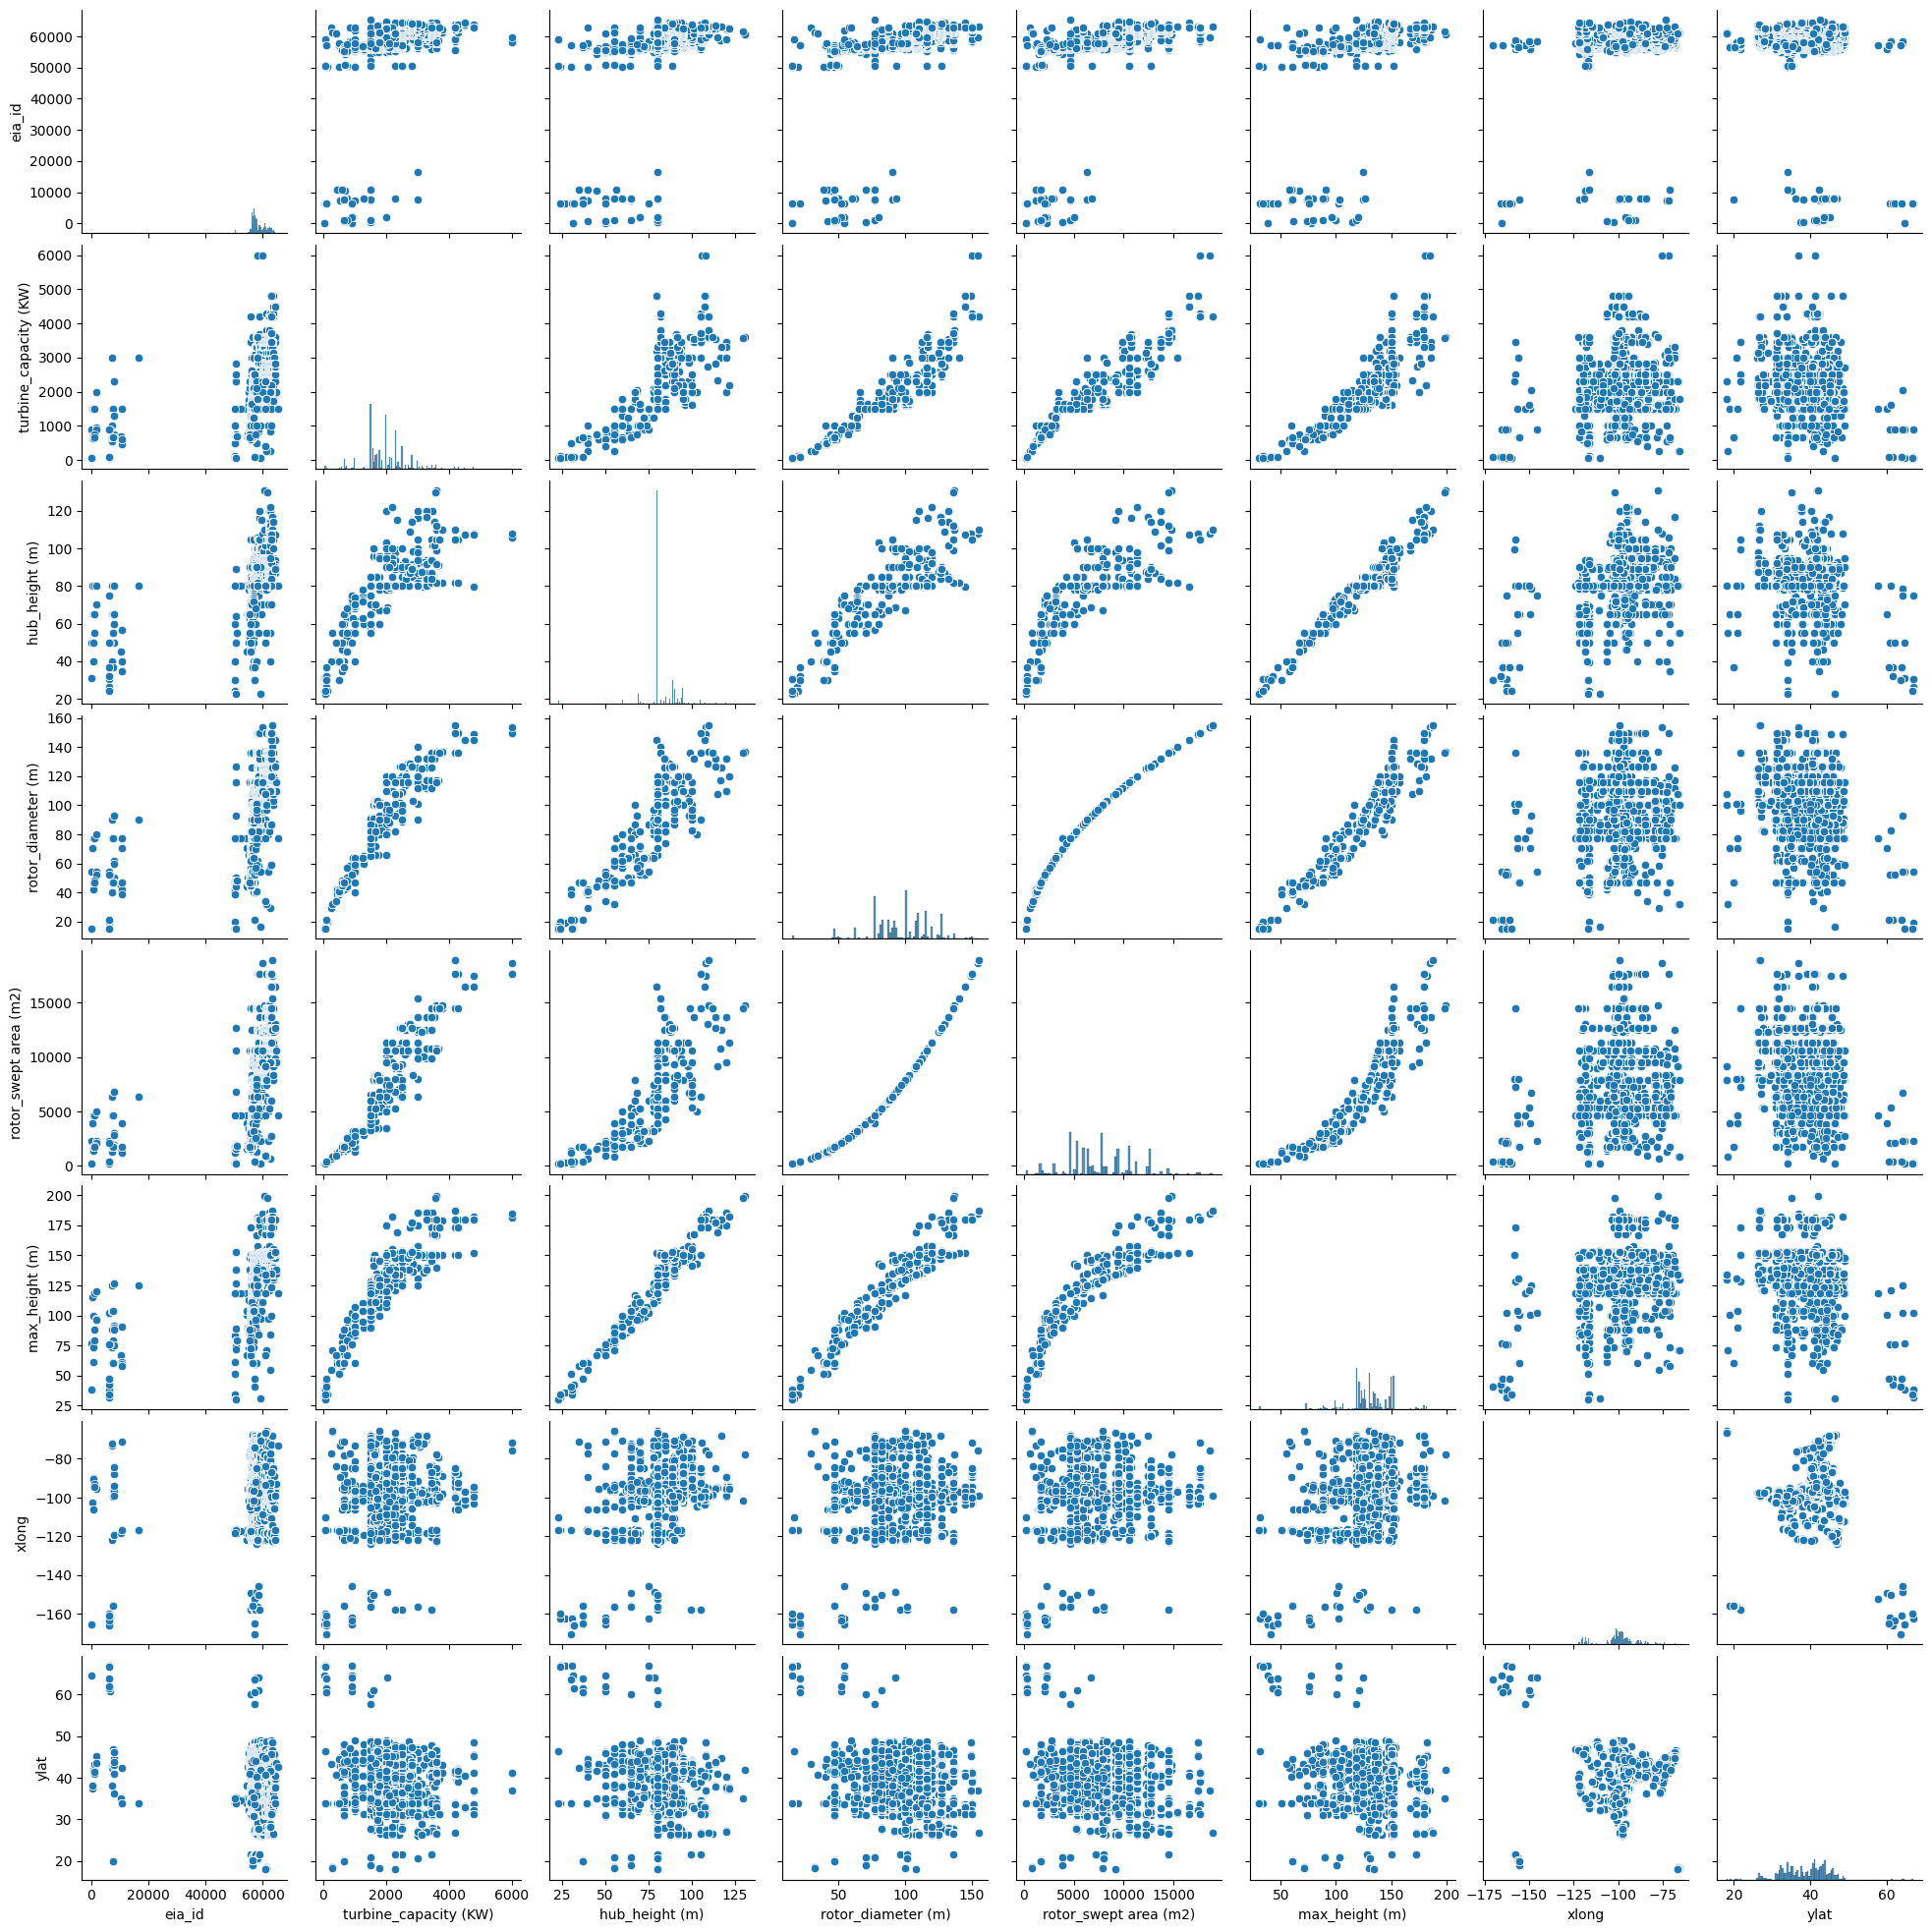

In [604]:
# plot a correlation matrix
import seaborn as sns
# remove xlong and ylat
corr_df = model_df.drop(['xlong','ylat','eia_id'], axis=1)
corr = corr_df.corr(numeric_only=True)

# show only half the heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask)

# plot a pairplot
sns.pairplot(model_df)

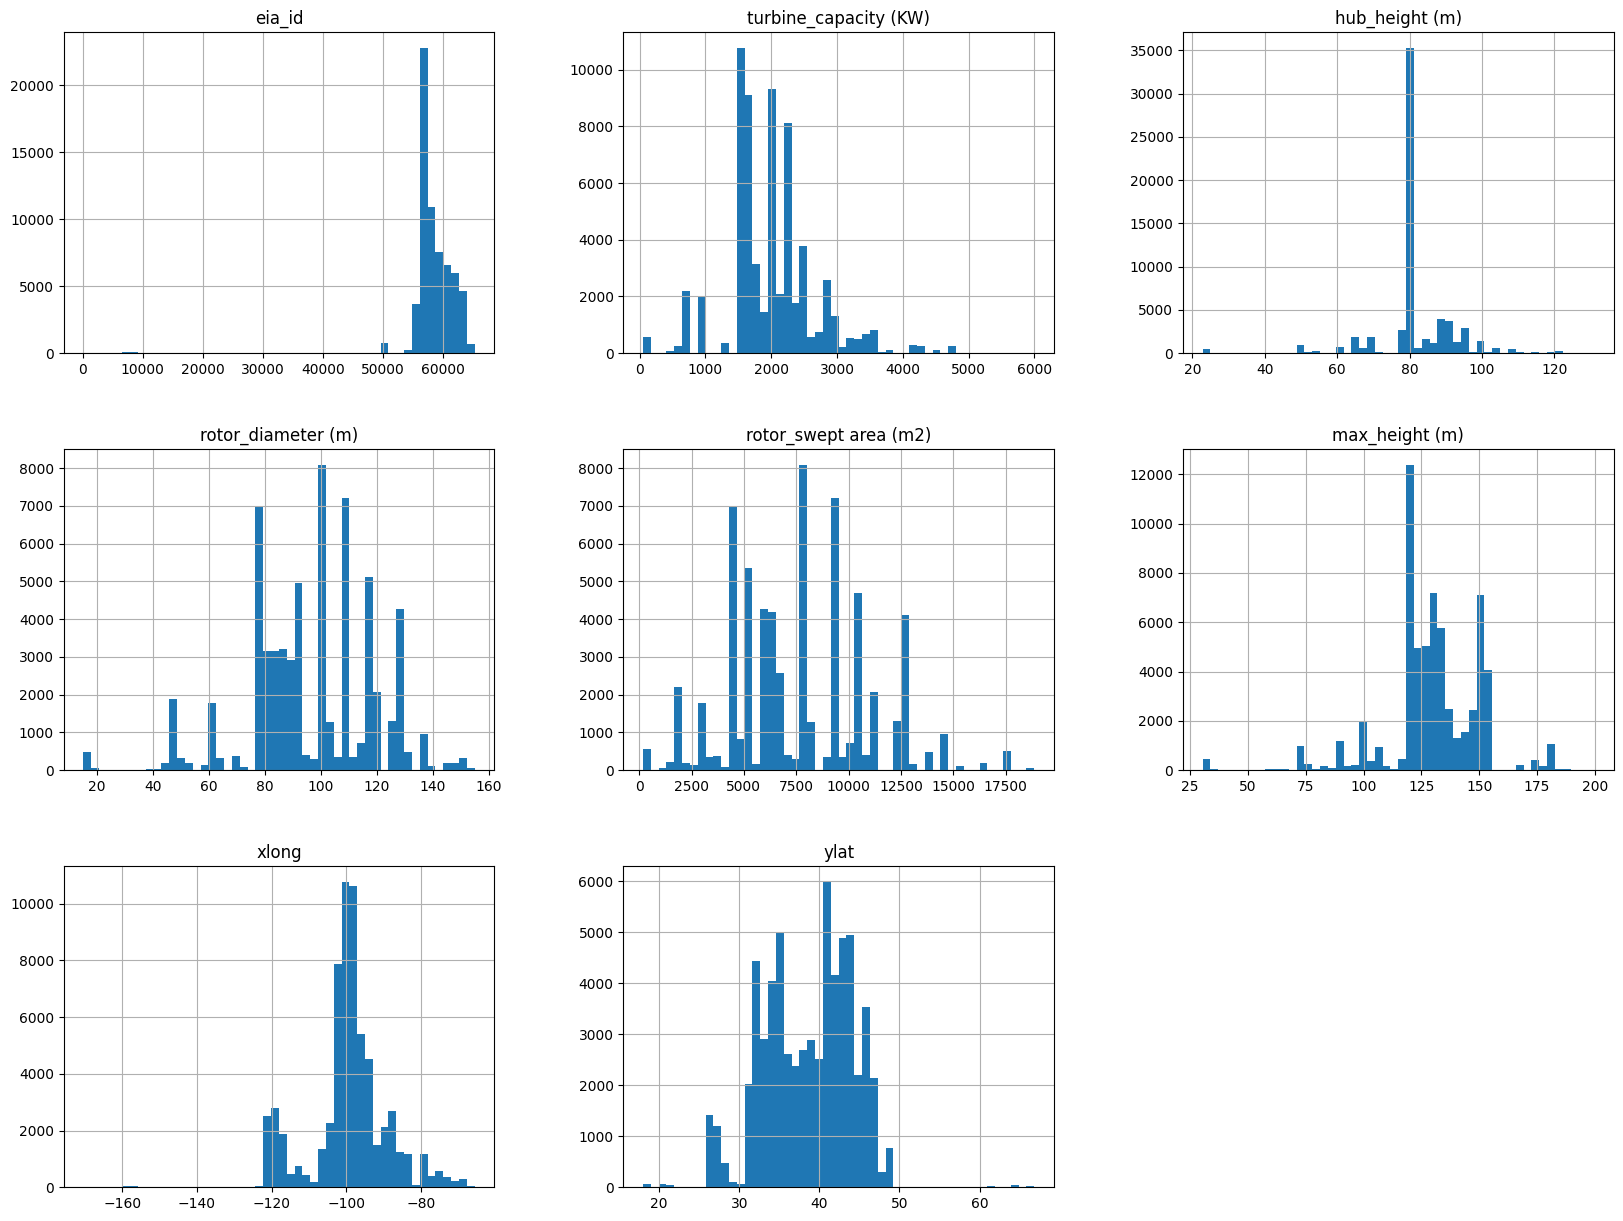

In [605]:
# plot histogram for each numerical feature
model_df.hist(bins=50, figsize=(20,15))
plt.show()

## 860 file

In [656]:
# read from second row
df_86 = pd.read_excel('Use this dataset/eia860_num_wt_Y2021.xlsx', skiprows=1)

In [607]:
df_86.head()

,Utility ID,Utility Name,Plant Code,Plant Name,State,County,Generator ID,Status,Technology,Prime Mover,Sector Name,Sector,Nameplate Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Operating Month,Operating Year,Number of Turbines,Predominant Turbine Manufacturer,Predominant Turbine Model Number,Design Wind Speed (mph),Wind Quality Class,Turbine Hub Height (Feet)
0,63560,"TDX Sand Point Generating, LLC",1,Sand Point,AK,Aleutians East,WT1,OS,Onshore Wind Turbine,WT,Electric Utility,1,0.50,0.10,0.10,10,2011,1,Vestas,V39-500,19.00,2,155.00
1,63560,"TDX Sand Point Generating, LLC",1,Sand Point,AK,Aleutians East,WT2,OA,Onshore Wind Turbine,WT,Electric Utility,1,0.50,0.30,0.30,10,2011,1,Vestas,V39-500,19.00,2,155.00
2,13642,Nome Joint Utility Systems,90,Snake River,AK,Nome,EWT 1,OP,Onshore Wind Turbine,WT,Electric Utility,1,0.90,0.90,0.90,7,2013,1,EWT,DW54-900,20.00,2,164.00
3,13642,Nome Joint Utility Systems,90,Snake River,AK,Nome,EWT 2,OP,Onshore Wind Turbine,WT,Electric Utility,1,0.90,0.90,0.90,7,2013,1,EWT,DW54-900,20.00,2,164.00
4,10633,City of Lamar - (CO),508,Lamar Plant,CO,Prowers,T1-T3,OP,Onshore Wind Turbine,WT,Electric Utility,1,4.50,4.00,4.00,2,2004,3,GE,1.5 XLE,19.00,2,262.40


In [657]:
# get nameplate capacity by plant Code
df_86 = df_86[['Plant Code', 'Nameplate Capacity (MW)', 'Summer Capacity (MW)', 'Winter Capacity (MW)','Number of Turbines','Sector Name','Utility Name']]

In [658]:
df_86.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485 entries, 0 to 1484
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Plant Code               1485 non-null   int64  
 1   Nameplate Capacity (MW)  1485 non-null   float64
 2   Summer Capacity (MW)     1485 non-null   float64
 3   Winter Capacity (MW)     1485 non-null   float64
 4   Number of Turbines       1485 non-null   int64  
 5   Sector Name              1485 non-null   object 
 6   Utility Name             1485 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 81.3+ KB


In [659]:
df_86.describe()

,Plant Code,Nameplate Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Number of Turbines
count,1485.00,1485.00,1485.00,1485.00,1485.00
mean,56441.23,89.87,89.40,89.34,46.54
std,10682.75,93.60,93.11,92.98,48.85
min,1.00,0.10,0.10,0.10,1.00
25%,56636.00,7.90,7.50,7.50,5.00
50%,57748.00,62.50,62.40,62.40,34.00
75%,60049.00,150.00,150.00,150.00,72.00
max,65484.00,600.00,582.30,582.30,460.00


In [660]:
# consolidate by Plant Code but include Sector Name and Utility Name
df_860 = df_86.groupby(['Plant Code','Sector Name','Utility Name']).sum().reset_index()

In [661]:
# reset index of df_860 but keep the column
df_860.head()

,Plant Code,Sector Name,Utility Name,Nameplate Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Number of Turbines
0,1,Electric Utility,"TDX Sand Point Generating, LLC",1.00,0.40,0.40,2
1,90,Electric Utility,Nome Joint Utility Systems,1.80,1.80,1.80,2
2,508,Electric Utility,City of Lamar - (CO),6.00,5.50,5.50,4
3,692,IPP Non-CHP,SRIV Partnership LLC,6.20,6.20,6.20,9
4,944,Electric Utility,City of Geneseo - (IL),3.00,3.00,3.00,2


## 923

In [613]:
df_92 = pd.read_excel('2023 Dataset/EIA923_Schedules_2_3_4_5_M_12_2021_Final_Revision.xlsx',skiprows=5)

In [614]:
df_92.head()

,Plant Id,Combined Heat And\nPower Plant,Nuclear Unit Id,Plant Name,Operator Name,Operator Id,Plant State,Census Region,NERC Region,Reserved,NAICS Code,EIA Sector Number,Sector Name,Reported\nPrime Mover,Reported\nFuel Type Code,AER\nFuel Type Code,Balancing\nAuthority Code,Respondent\nFrequency,Physical\nUnit Label,Quantity\nJanuary,Quantity\nFebruary,Quantity\nMarch,Quantity\nApril,Quantity\nMay,Quantity\nJune,Quantity\nJuly,Quantity\nAugust,Quantity\nSeptember,Quantity\nOctober,Quantity\nNovember,Quantity\nDecember,Elec_Quantity\nJanuary,Elec_Quantity\nFebruary,Elec_Quantity\nMarch,Elec_Quantity\nApril,Elec_Quantity\nMay,Elec_Quantity\nJune,Elec_Quantity\nJuly,Elec_Quantity\nAugust,Elec_Quantity\nSeptember,Elec_Quantity\nOctober,Elec_Quantity\nNovember,Elec_Quantity\nDecember,MMBtuPer_Unit\nJanuary,MMBtuPer_Unit\nFebruary,MMBtuPer_Unit\nMarch,MMBtuPer_Unit\nApril,MMBtuPer_Unit\nMay,MMBtuPer_Unit\nJune,MMBtuPer_Unit\nJuly,MMBtuPer_Unit\nAugust,MMBtuPer_Unit\nSeptember,MMBtuPer_Unit\nOctober,MMBtuPer_Unit\nNovember,MMBtuPer_Unit\nDecember,Tot_MMBtu\nJanuary,Tot_MMBtu\nFebruary,Tot_MMBtu\nMarch,Tot_MMBtu\nApril,Tot_MMBtu\nMay,Tot_MMBtu\nJune,Tot_MMBtu\nJuly,Tot_MMBtu\nAugust,Tot_MMBtu\nSeptember,Tot_MMBtu\nOctober,Tot_MMBtu\nNovember,Tot_MMBtu\nDecember,Elec_MMBtu\nJanuary,Elec_MMBtu\nFebruary,Elec_MMBtu\nMarch,Elec_MMBtu\nApril,Elec_MMBtu\nMay,Elec_MMBtu\nJune,Elec_MMBtu\nJuly,Elec_MMBtu\nAugust,Elec_MMBtu\nSeptember,Elec_MMBtu\nOctober,Elec_MMBtu\nNovember,Elec_MMBtu\nDecember,Netgen\nJanuary,Netgen\nFebruary,Netgen\nMarch,Netgen\nApril,Netgen\nMay,Netgen\nJune,Netgen\nJuly,Netgen\nAugust,Netgen\nSeptember,Netgen\nOctober,Netgen\nNovember,Netgen\nDecember,Total Fuel Consumption\nQuantity,Electric Fuel Consumption\nQuantity,Total Fuel Consumption\nMMBtu,Elec Fuel Consumption\nMMBtu,Net Generation\n(Megawatthours),YEAR
0,1,N,.,Sand Point,"TDX Sand Point Generating, LLC",63560,AK,PACN,NaN,NaN,22,1,Electric Utility,IC,DFO,DFO,NaN,A,barrels,466,514,556,535,277,372,363,524,679,674,526,585,466,514,556,535,277,372,363,524,679,674,526,585,5.85,5.85,5.85,5.85,5.85,5.85,5.85,5.85,5.85,5.85,5.85,5.85,2724,3005,3250,3128,1619,2175,2122,3063,3969,3940,3075,3420,2724,3005,3250,3128,1619,2175,2122,3063,3969,3940,3075,3420,208.84,231.25,250.10,240.41,124.50,167.13,163.33,235.54,305.07,303.10,236.66,263.08,6071,6071,35490,35490,2729.00,2021
1,1,N,.,Sand Point,"TDX Sand Point Generating, LLC",63560,AK,PACN,NaN,NaN,22,1,Electric Utility,WT,WND,WND,NaN,A,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,103,78,97,77,91,94,111,113,115,117,66,122,103,78,97,77,91,94,111,113,115,117,66,122,11.61,8.84,11.01,8.74,10.33,10.67,12.57,12.74,13.05,13.18,7.49,13.76,0,0,1184,1184,134.00,2021
2,2,N,.,Bankhead Dam,Alabama Power Co,195,AL,ESC,SERC,NaN,22,1,Electric Utility,HY,WAT,HYC,SOCO,A,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,193267,160812,154227,136040,168541,181467,161573,152459,125050,128322,150396,193250,193267,160812,154227,136040,168541,181467,161573,152459,125050,128322,150396,193250,21852.91,18183.22,17438.64,15382.20,19057.05,20518.62,18269.28,17238.67,14139.51,14509.50,17005.42,21850.98,0,0,1905404,1905404,215446.00,2021
3,3,N,.,Barry,Alabama Power Co,195,AL,ESC,SERC,NaN,22,1,Electric Utility,CA,NG,NG,SOCO,M,mcf,37837,24972,22230,48459,63513,87775,59474,62849,42565,75889,25392,55729,37837,24972,22230,48459,63513,87775,59474,62849,42565,75889,25392,55729,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.02,1.02,1.01,1.01,38405,25347,22563,49186,64466,88916,60366,63666,43246,77103,25722,56398,38405,25347,22563,49186,64466,88916,60366,63666,43246,77103,25722,56398,267855,211532,151640,208134,246122,253273,262176,262090,168852,218962,239159,215057,606684,606684,615384,615384,2704852.00,2021
4,3,N,.,Barry,Alabama Power Co,195,AL,ESC,SERC,NaN,22,1,Electric Utility,CT,NG,NG,SOCO,M,mcf,5414508,4389152,3125633,4196931,4824327,5009255,5187450,5264905,3393647,4352037,4690624,4249030,5414508,4389152,312563

In [615]:
df_923 = df_92[['Plant Id', 'Reported\nPrime Mover','Plant State', 'Census Region', 'NERC Region','Elec Fuel Consumption\nMMBtu', 'Net Generation\n(Megawatthours)']]

In [616]:
# only keep WT and WS from Reported\nPrime Mover
df_923 = df_923[(df_923['Reported\nPrime Mover'] == 'WT') | (df_923['Reported\nPrime Mover'] == 'WS')]

In [617]:
df_923.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1280 entries, 1 to 15795
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Plant Id                        1280 non-null   int64  
 1   Reported
Prime Mover            1280 non-null   object 
 2   Plant State                     1280 non-null   object 
 3   Census Region                   1280 non-null   object 
 4   NERC Region                     1256 non-null   object 
 5   Elec Fuel Consumption
MMBtu     1280 non-null   int64  
 6   Net Generation
(Megawatthours)  1280 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 80.0+ KB


## Combining the dfs

In [663]:
print(f'there are {df_860["Plant Code"].nunique()} number of plants')
print(f'the shape is {df_860.shape}')

there are 1280 number of plants
the shape is (1280, 7)


In [664]:
print(f"there are {df_923['Plant Id'].nunique()} number of plants")
print(f'the shape is {df_923.shape}')

there are 1279 number of plants
the shape is (1280, 7)


In [665]:
# find out which Plant Id is missing from df_923 comapred to Plant Code from df_860
missing_plants = set(df_860['Plant Code']) - set(df_923['Plant Id'])
print(f'the ids missing from 923 are {missing_plants}')
missing_plants2 = set(df_923['Plant Id']) - set(df_860['Plant Code'])
print(f'the ids missing from 860 are {missing_plants2}')

the ids missing from 923 are {65129, 57547, 57517, 59022, 59023, 57263, 57264}
the ids missing from 860 are {55719, 56779, 57741, 59825, 58424, 99999}


In [666]:
# do an inner join between 860 and 923
intermediate_df = df_923.merge(df_860, left_on='Plant Id', right_on='Plant Code', how='inner')

In [667]:
print(f"there are {model_df['eia_id'].nunique()} number of plants")
print(f'the shape is {model_df.shape}')

there are 1186 number of plants
the shape is (64007, 8)


In [668]:
missing_plants = set(intermediate_df['Plant Code']) - set(model_df['eia_id'])
print(f'the ids missing from model_df are {missing_plants}')
missing_plants2 = set(model_df['eia_id']) - set(intermediate_df['Plant Code'])
print(f'the ids missing from intermediate_df are {missing_plants2}')

the ids missing from model_df are {1, 61442, 64003, 61444, 56840, 56336, 65048, 54299, 54300, 56587, 65059, 56588, 61990, 56589, 58925, 64051, 64052, 64053, 64054, 64065, 64066, 63574, 56409, 56410, 56411, 56412, 62570, 61041, 58995, 65143, 64638, 62592, 64130, 50820, 50821, 64138, 61583, 54931, 64662, 58025, 64172, 59053, 62642, 64178, 64183, 2240, 64710, 63689, 64230, 58089, 64750, 56570, 58112, 55561, 55562, 55563, 55564, 55565, 56586, 55567, 55568, 55569, 55570, 55571, 55572, 10005, 55573, 65316, 61734, 57136, 56626, 64332, 64336, 59223, 59224, 59225, 59226, 59227, 59228, 59736, 59230, 59231, 59232, 62809, 59235, 50532, 50533, 10597, 59757, 54647, 62333, 64381, 62855, 56199, 62857, 56200, 56201, 56202, 56204, 56205, 56206, 56207, 56208, 56209, 59797, 64407, 63384, 54686, 59295, 57248, 63393, 59817, 52142, 57791, 57792, 52162, 52163, 65478, 63431, 63432, 63433, 65479, 65484, 1998, 10191, 56275, 56276, 62935, 54750, 62442, 57835, 63981, 56824, 56825, 63482, 56827, 56828}
the ids miss

In [669]:
turbine_df = model_df.groupby('eia_id').mean()

In [670]:
turbine_df.head()

,turbine_capacity (KW),hub_height (m),rotor_diameter (m),rotor_swept area (m2),max_height (m),xlong,ylat
eia_id,,,,,,,
90.00,150.00,33.32,19.59,425.36,43.13,-165.43,64.57
508.00,1500.00,80.00,70.50,3903.63,115.20,-102.56,37.90
692.00,696.67,47.78,45.89,1657.27,70.72,-106.24,41.83
944.00,1500.00,65.00,77.00,4656.63,100.00,-90.15,41.43
1158.00,750.00,55.00,48.00,1809.56,78.90,-94.54,40.90


In [671]:
# do an inner join between turbine_df and intermediate_df
final_df = intermediate_df.merge(turbine_df, left_on='Plant Code', right_on='eia_id', how='inner')

In [672]:
# remove 0 values from net generation
final_df = final_df[final_df['Net Generation\n(Megawatthours)'] != 0]
# remove 0 values from elec fuel consumption
final_df = final_df[final_df['Elec Fuel Consumption\nMMBtu'] != 0]

In [673]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1124 entries, 0 to 1135
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Plant Id                        1124 non-null   int64  
 1   Reported
Prime Mover            1124 non-null   object 
 2   Plant State                     1124 non-null   object 
 3   Census Region                   1124 non-null   object 
 4   NERC Region                     1111 non-null   object 
 5   Elec Fuel Consumption
MMBtu     1124 non-null   int64  
 6   Net Generation
(Megawatthours)  1124 non-null   float64
 7   Plant Code                      1124 non-null   int64  
 8   Sector Name                     1124 non-null   object 
 9   Utility Name                    1124 non-null   object 
 10  Nameplate Capacity (MW)         1124 non-null   float64
 11  Summer Capacity (MW)            1124 non-null   float64
 12  Winter Capacity (MW)            11

In [674]:
final_df['uptime'] = final_df['Net Generation\n(Megawatthours)']/final_df['Nameplate Capacity (MW)']
final_df['efficiency'] = final_df['Net Generation\n(Megawatthours)']/final_df['Elec Fuel Consumption\nMMBtu']
final_df['avg_tgen'] = final_df['Net Generation\n(Megawatthours)']/final_df['Number of Turbines']
final_df['avg_fuel'] = final_df['Elec Fuel Consumption\nMMBtu']/final_df['Number of Turbines']
final_df['avg_tcap'] = final_df['Nameplate Capacity (MW)']/final_df['Number of Turbines']

In [675]:
final_df.head()

,Plant Id,Reported\nPrime Mover,Plant State,Census Region,NERC Region,Elec Fuel Consumption\nMMBtu,Net Generation\n(Megawatthours),Plant Code,Sector Name,Utility Name,Nameplate Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Number of Turbines,turbine_capacity (KW),hub_height (m),rotor_diameter (m),rotor_swept area (m2),max_height (m),xlong,ylat,uptime,efficiency,avg_tgen,avg_fuel,avg_tcap
0,90,WT,AK,PACN,NaN,18837,2130.00,90,Electric Utility,Nome Joint Utility Systems,1.80,1.80,1.80,2,150.00,33.32,19.59,425.36,43.13,-165.43,64.57,1183.33,0.11,1065.00,9418.50,0.90
1,508,WT,CO,MTN,WECC,112709,12744.00,508,Electric Utility,City of Lamar - (CO),6.00,5.50,5.50,4,1500.00,80.00,70.50,3903.63,115.20,-102.56,37.90,2124.00,0.11,3186.00,28177.25,1.50
2,692,WT,WY,MTN,WECC,160021,18094.00,692,IPP Non-CHP,SRIV Partnership LLC,6.20,6.20,6.20,9,696.67,47.78,45.89,1657.27,70.72,-106.24,41.83,2918.39,0.11,2010.44,17780.11,0.69
3,944,WT,IL,ENC,MRO,54470,6159.00,944,Electric Utility,City of Geneseo - (IL),3.00,3.00,3.00,2,1500.00,65.00,77.00,4656.63,100.00,-90.15,41.43,2053.00,0.11,3079.50,27235.00,1.50
4,1172,WT,IA,WNC,MRO,37198,4206.00,1172,Electric Utility,City of Osage - (IA),1.60,0.50,0.50,1,1500.00,80.00,77.00,4656.63,118.60,-92.84,43.29,2628.75,0.11,4206.00,37198.00,1.60


In [676]:
# show in 2 decimal places
pd.options.display.float_format = '{:.2f}'.format
final_df.describe()

,Plant Id,Elec Fuel Consumption\nMMBtu,Net Generation\n(Megawatthours),Plant Code,Nameplate Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Number of Turbines,turbine_capacity (KW),hub_height (m),rotor_diameter (m),rotor_swept area (m2),max_height (m),xlong,ylat,uptime,efficiency,avg_tgen,avg_fuel,avg_tcap
count,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00
mean,57533.07,2927454.00,331010.08,57533.07,112.02,111.40,111.47,57.22,2005.95,81.21,94.52,7381.93,128.49,-98.46,39.81,2748.32,0.11,5569.67,49258.18,1.99
std,7499.89,3000618.80,339283.04,7499.89,102.36,101.91,101.93,53.36,690.12,10.66,21.34,3170.03,19.94,14.10,5.45,927.21,0.00,2815.53,24900.55,0.70
min,90.00,478.00,54.00,90.00,1.00,0.40,0.50,1.00,150.00,28.59,19.59,425.36,41.53,-165.43,18.97,13.73,0.11,1.35,11.93,0.10
25%,56803.00,512579.75,57958.00,56803.00,23.00,22.73,22.73,12.75,1500.00,80.00,82.00,5281.02,121.00,-103.13,35.46,2125.45,0.11,3650.57,32285.65,1.50
50%,57768.00,2132911.50,241170.50,57768.00,99.00,98.95,98.95,48.00,2000.00,80.00,92.49,6720.06,126.50,-98.33,41.11,2763.77,0.11,5267.77,46588.13,2.00
75%,59969.00,4461366.00,504451.25,59969.00,174.85,174.65,174.85,87.00,2305.36,85.00,110.00,9503.32,139.90,-92.72,43.55,3486.22,0.11,7304.81,64603.76,2.30
max,64623.00,20464778.00,2313973.00,64623.00,735.50,735.50,735.50,426.00,6000.00,130.00,155.00,18869.19,198.10,-67.81,66.84,5750.48,0.11,24791.50,219256.50,6.00


In [677]:
# put to csv
final_df.to_csv('final_df.csv', index=False)

<AxesSubplot: >

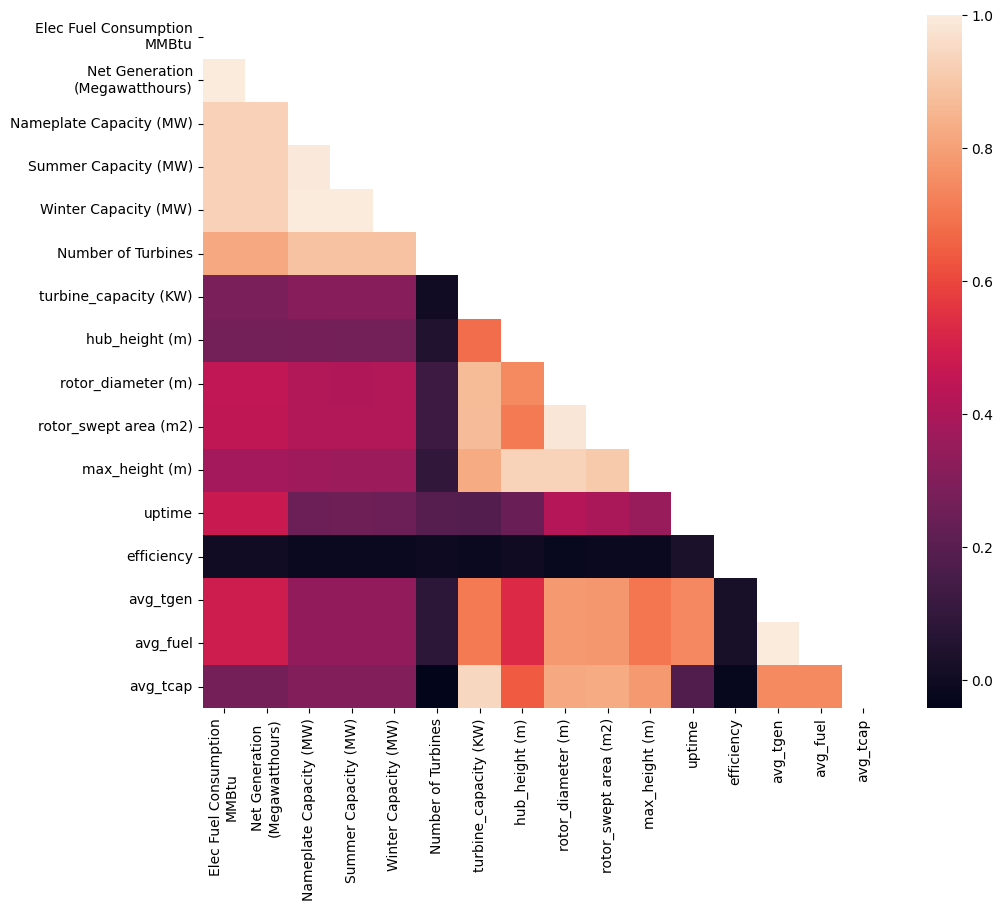

In [678]:
# remove xlong and ylat
corr_df = final_df.drop(['xlong','ylat','Plant Code','Plant Id'], axis=1)
corr = corr_df.corr(numeric_only=True)

# show only half the heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask)

## Pipeline

In [679]:
models = [
        ('KM', KMeans()),
        ('AC', AgglomerativeClustering()),
        ('BIR', Birch()),
        ('MBKM', MiniBatchKMeans()),
        ('OPT', OPTICS()),
        ('SC', SpectralClustering())
        # ('MS', MeanShift()),
        # ('DB', DBSCAN()),
        # ('AP', AffinityPropagation())
        ]

In [680]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1124 entries, 0 to 1135
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Plant Id                        1124 non-null   int64  
 1   Reported
Prime Mover            1124 non-null   object 
 2   Plant State                     1124 non-null   object 
 3   Census Region                   1124 non-null   object 
 4   NERC Region                     1111 non-null   object 
 5   Elec Fuel Consumption
MMBtu     1124 non-null   int64  
 6   Net Generation
(Megawatthours)  1124 non-null   float64
 7   Plant Code                      1124 non-null   int64  
 8   Sector Name                     1124 non-null   object 
 9   Utility Name                    1124 non-null   object 
 10  Nameplate Capacity (MW)         1124 non-null   float64
 11  Summer Capacity (MW)            1124 non-null   float64
 12  Winter Capacity (MW)            11

In [681]:
# drop features
dropped_features = ['xlong', 'ylat', 'Plant Id','Reported\nPrime Mover','Plant State', 'Census Region', 'NERC Region','Plant Code',
                    'Number of Turbines','turbine_capacity (KW)','Sector Name','Utility Name',
                    'Net Generation\n(Megawatthours)', 'Elec Fuel Consumption\nMMBtu', 'Nameplate Capacity (MW)', 'Summer Capacity (MW)', 'Winter Capacity (MW)',
                    'hub_height (m)', 'rotor_diameter (m)', 'rotor_swept area (m2)', 'max_height (m)']

In [682]:
X = final_df.drop(dropped_features, axis=1)

In [683]:
# setup the ordinal features
# ordinal_features = ['education']
# order = [['basic.4y', 'basic.6y','basic.9y', 'high.school','professional.course','university.degree']]

# setup the numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
# for idp_var in ordinal_features:
    # while idp_var in categorical_features:
        # categorical_features.remove(idp_var)

In [684]:
inertia = []
s_score = []
db_score = []
ch_score = []
clusters = [2,3,4,5,6]

preprocessor = ColumnTransformer(transformers=[
    ('tnf1',MinMaxScaler(),numerical_features),
    # ('tnf2',OrdinalEncoder(categories=order),ordinal_features),
    ('tnf3',OneHotEncoder(),categorical_features)
# ])
], remainder='passthrough')

print('intertia: lower is better, s_score: close to 1 is better, db_score: closer to 0 is better, ch_score: higher is better')

# optimize clusters for unknown data labels
for name, model in models:
    for i in clusters:
        n_model = KMeans(n_clusters = i, random_state =42)
        
        print(f'running {model} with {i} clusters')    
        pipeline = Pipeline([('preprocessor', preprocessor),
                            #  ("dimred_step", PCA(n_components=4)),
                             ('cluster', n_model)])
        pipeline.fit(X)
        inertia.append(pipeline.named_steps['cluster'].inertia_)
        print(f'for clusters = {i}, the inertia is : {pipeline.named_steps["cluster"].inertia_}')
        cluster_labels = pipeline.named_steps['cluster'].labels_

        silhouette_avg = silhouette_score(X, cluster_labels)
        s_score.append(silhouette_avg)
        print(f'for clusters = {i}, the average silhouette_score is : {silhouette_avg}')

        db = davies_bouldin_score(X, cluster_labels)
        db_score.append(db)
        print(f'for clusters = {i}, the Davies-Bouldin Index is : {db}')

        ch = calinski_harabasz_score(X, cluster_labels)
        ch_score.append(ch)
        print(f'for clusters = {i}, the Calinski-Harabasz Index is : {ch}')

        print(len(cluster_labels))
        
    break

intertia: lower is better, s_score: close to 1 is better, db_score: closer to 0 is better, ch_score: higher is better
running KMeans() with 2 clusters
for clusters = 2, the inertia is : 39.11408372454437
for clusters = 2, the average silhouette_score is : 0.505154902355006
for clusters = 2, the Davies-Bouldin Index is : 0.6438959431522835
for clusters = 2, the Calinski-Harabasz Index is : 1606.7284513243287
1124
running KMeans() with 3 clusters
for clusters = 3, the inertia is : 29.023193454090077
for clusters = 3, the average silhouette_score is : 0.4643137056592282
for clusters = 3, the Davies-Bouldin Index is : 0.6260816112733488
for clusters = 3, the Calinski-Harabasz Index is : 1947.502195153328
1124
running KMeans() with 4 clusters
for clusters = 4, the inertia is : 23.545118246276378
for clusters = 4, the average silhouette_score is : 0.32866366592621865
for clusters = 4, the Davies-Bouldin Index is : 0.8443184478395926
for clusters = 4, the Calinski-Harabasz Index is : 1519.171

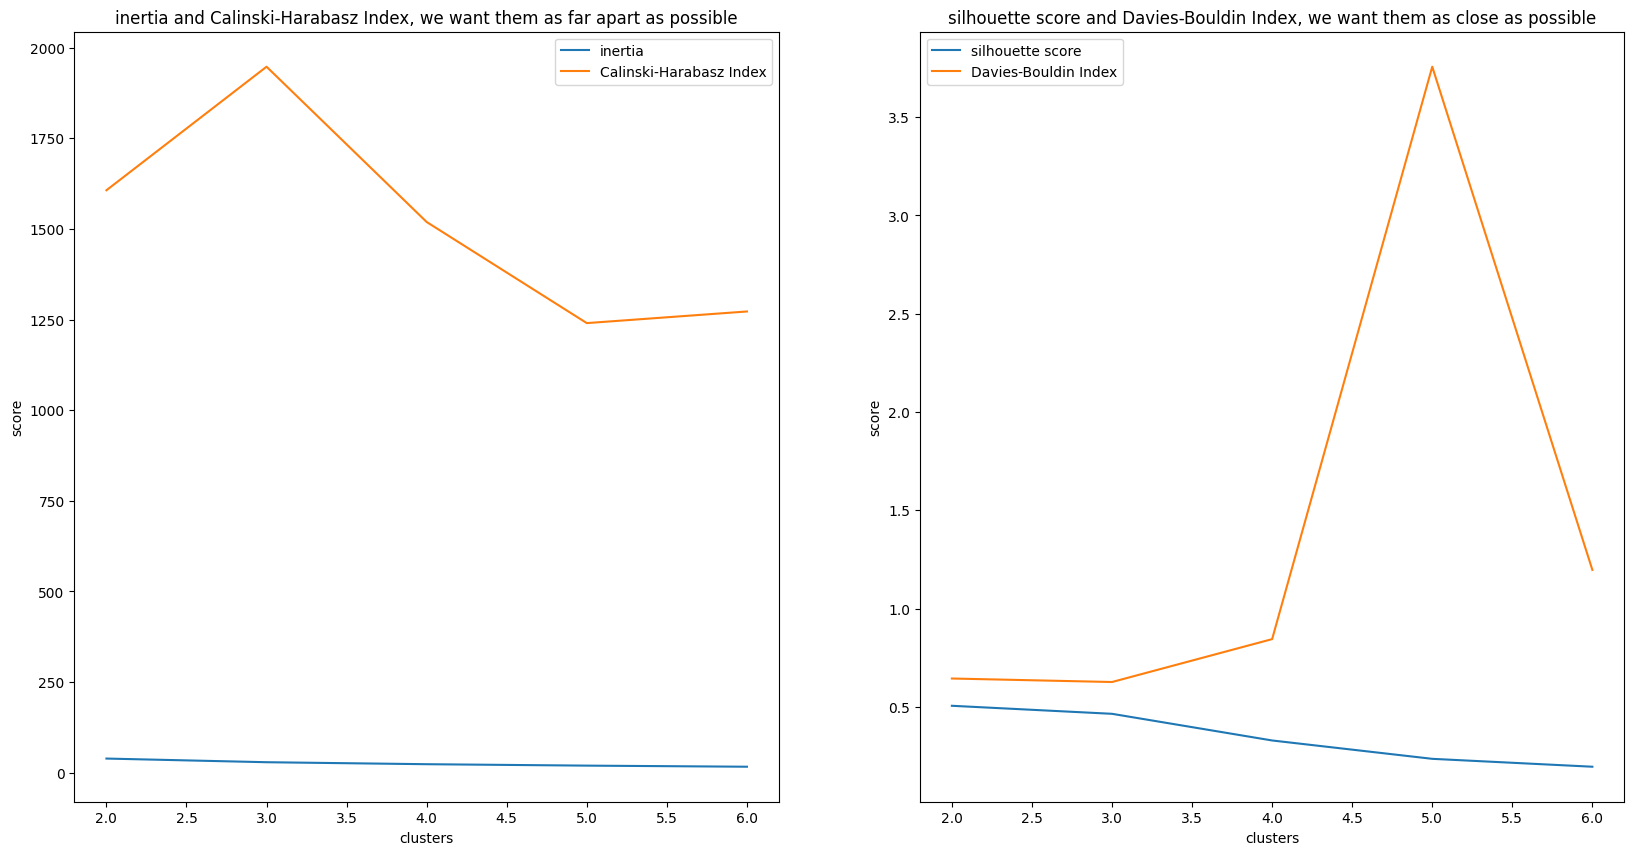

In [685]:
# plot inertia and Calinski-Harabasz Index on one index, silhouette score and Davies-Bouldin Index on another
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(clusters, inertia, label='inertia')
ax[0].plot(clusters, ch_score, label='Calinski-Harabasz Index')
ax[0].set_title('inertia and Calinski-Harabasz Index, we want them as far apart as possible')
ax[0].set_xlabel('clusters')
ax[0].set_ylabel('score')
ax[0].legend()

ax[1].plot(clusters, s_score, label='silhouette score')
ax[1].plot(clusters, db_score, label='Davies-Bouldin Index')
ax[1].set_title('silhouette score and Davies-Bouldin Index, we want them as close as possible')
ax[1].set_xlabel('clusters')
ax[1].set_ylabel('score')
ax[1].legend()

In [686]:
# we found optimal k is 4
n_model = KMeans(n_clusters = 3, random_state =42)
pipeline = Pipeline([('preprocessor', preprocessor),
                    #  ("dimred_step", PCA(n_components=4)),
                        ('cluster', n_model)])
pipeline.fit(X)
cluster_labels = pipeline.named_steps['cluster'].labels_

In [687]:
final_copy = final_df.copy()

# append cluster_labels to final_df
final_copy['cluster'] = cluster_labels

In [688]:
final_copy.cluster.value_counts()

1    495
0    369
2    260
Name: cluster, dtype: int64

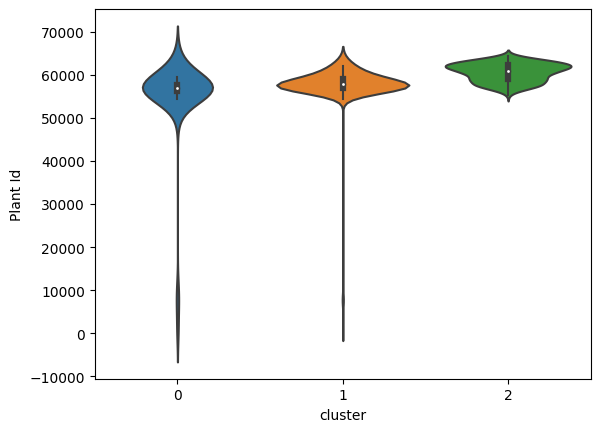

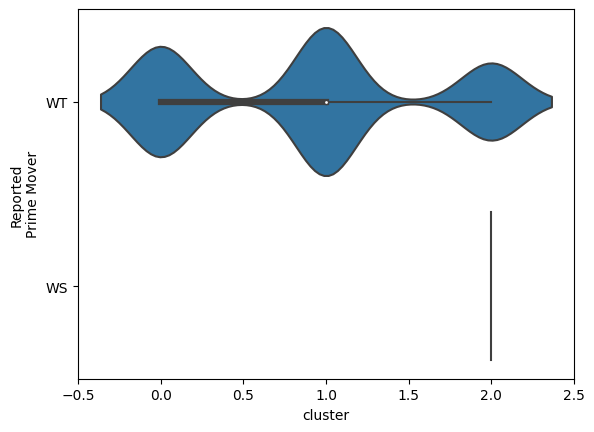

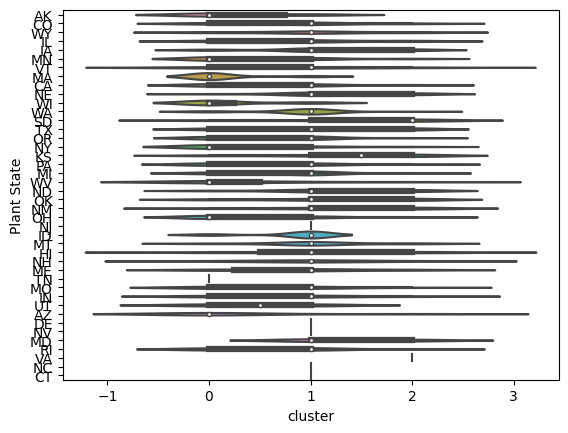

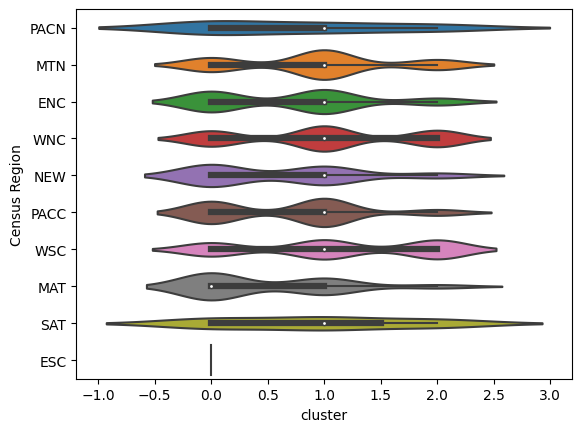

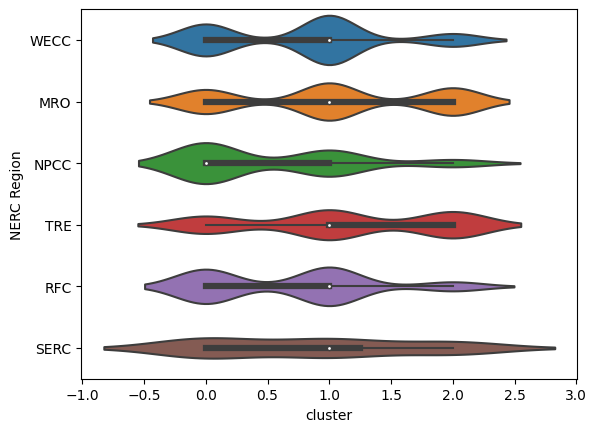

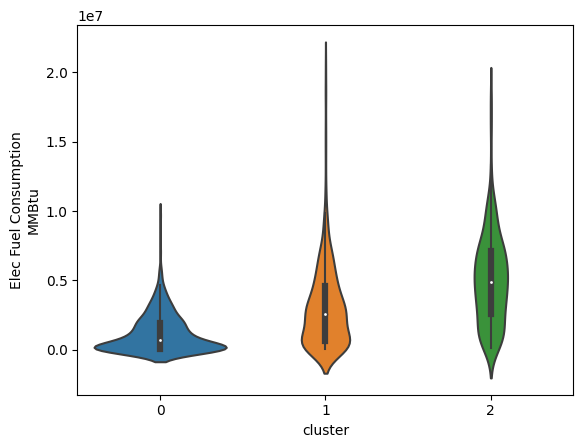

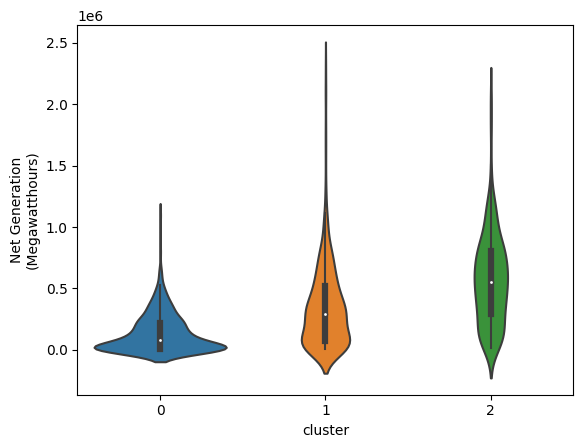

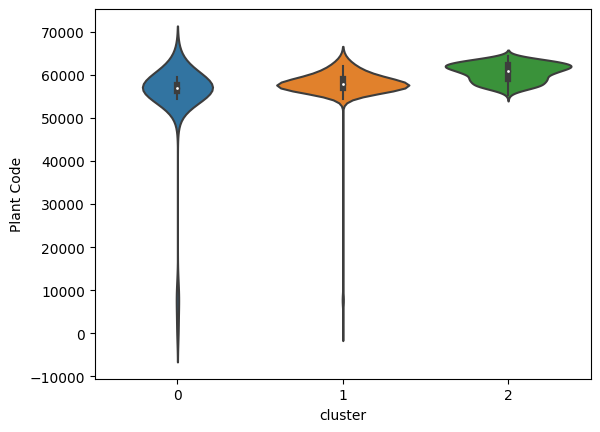

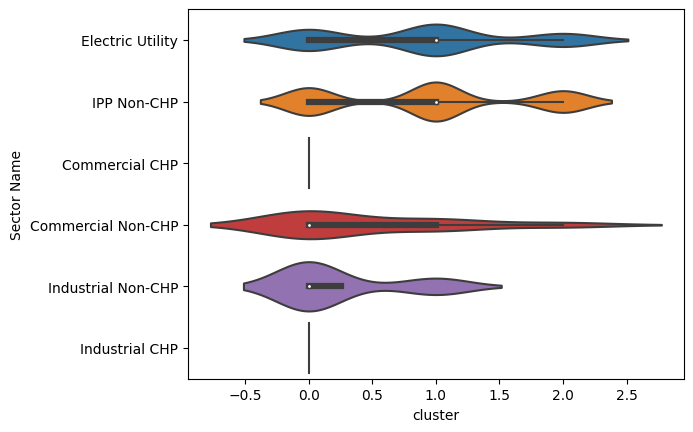

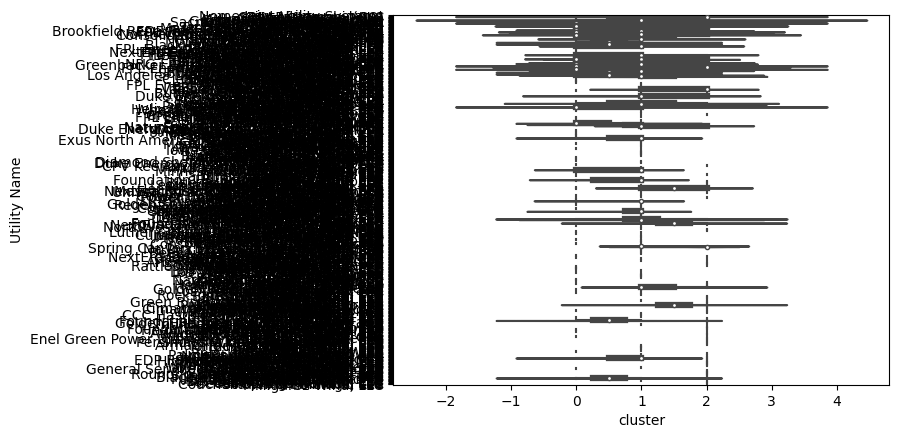

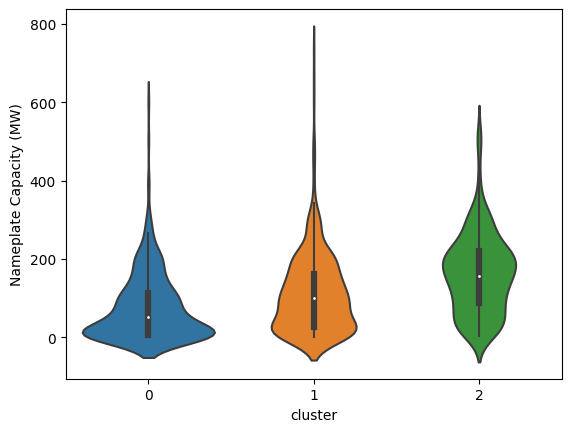

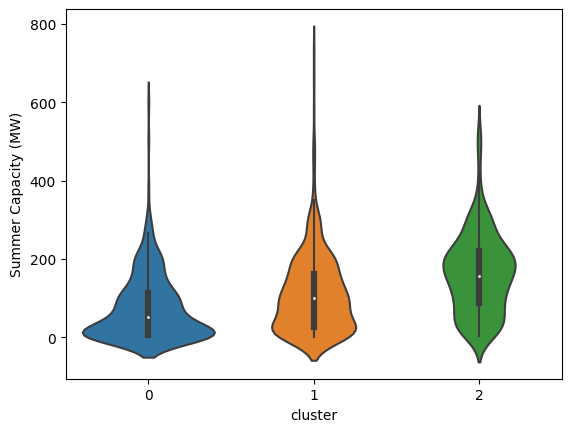

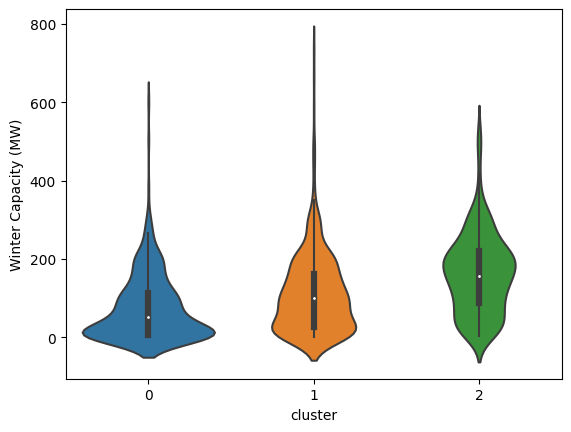

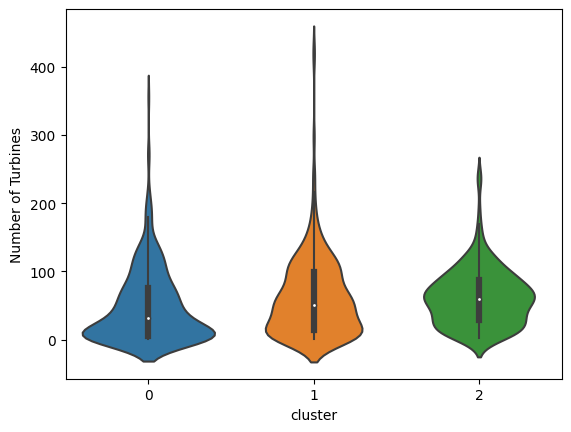

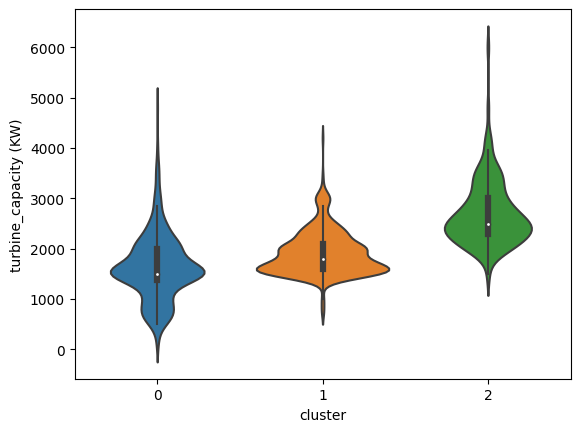

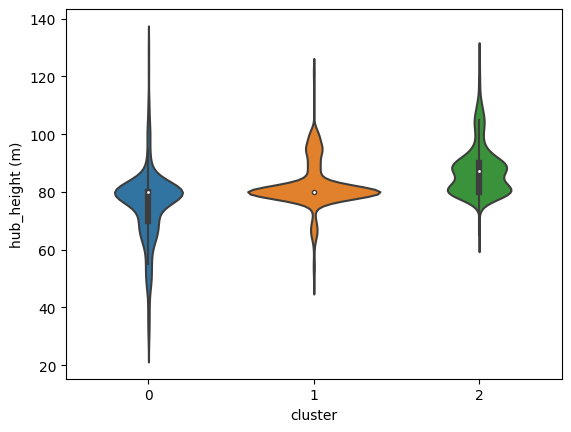

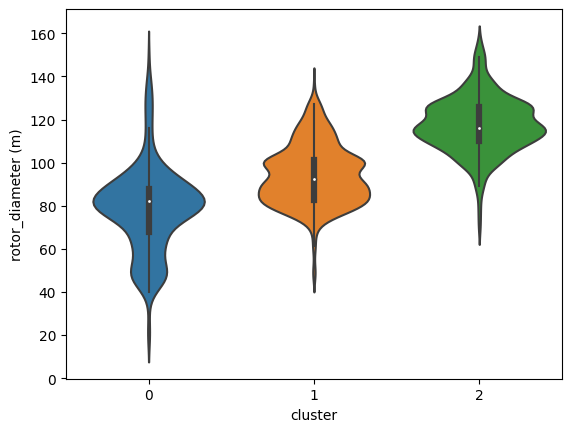

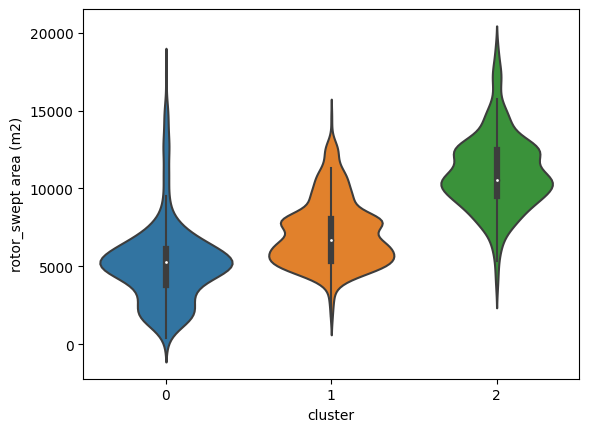

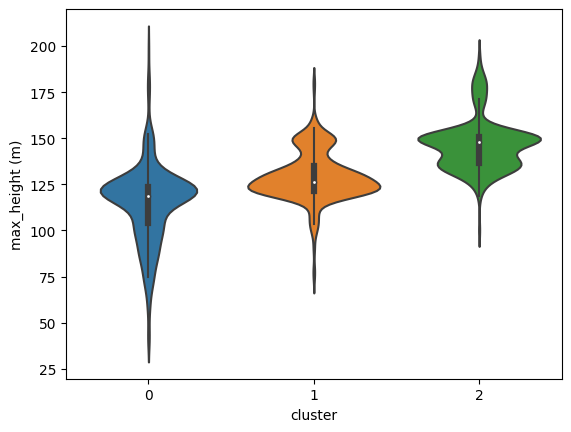

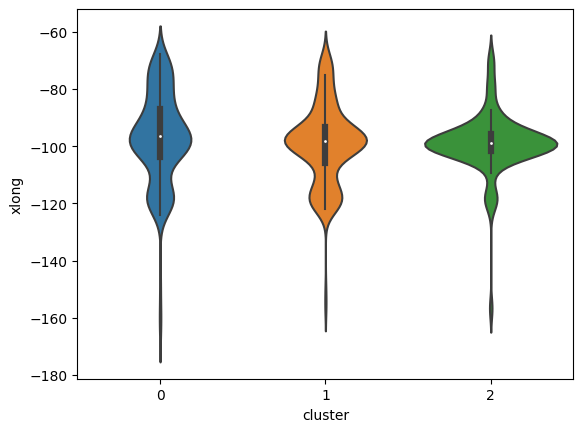

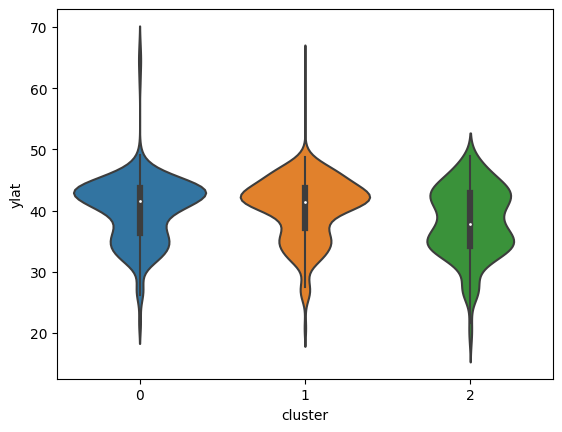

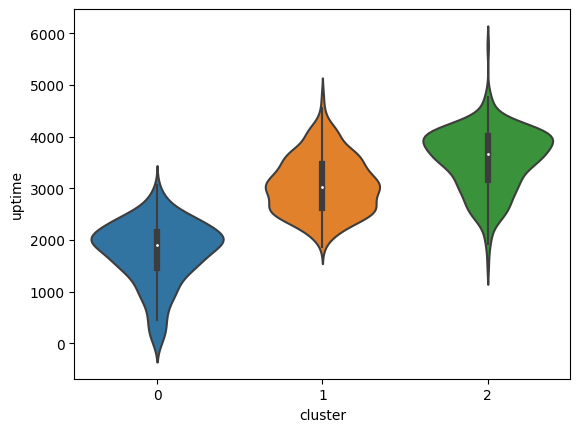

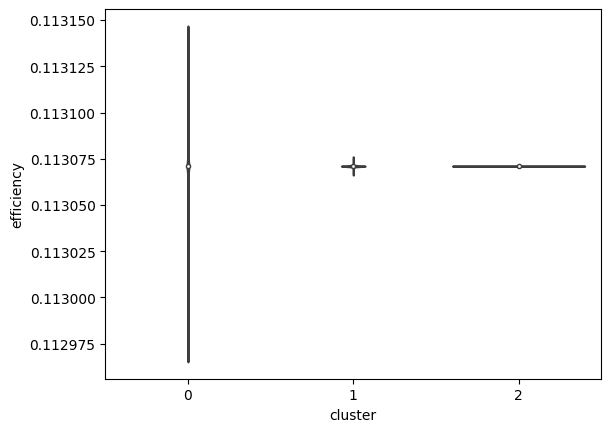

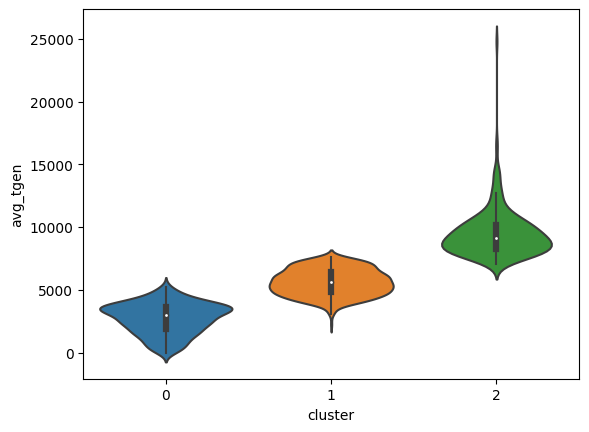

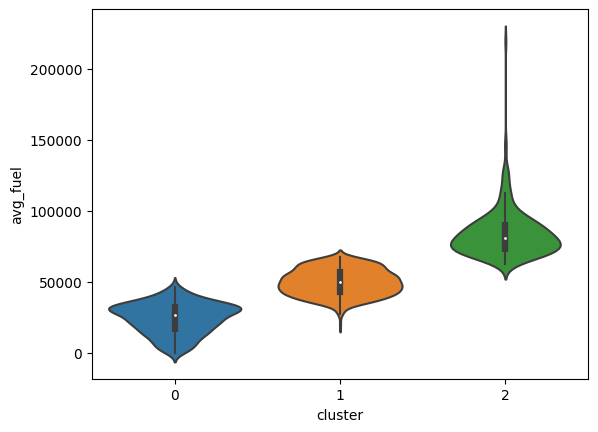

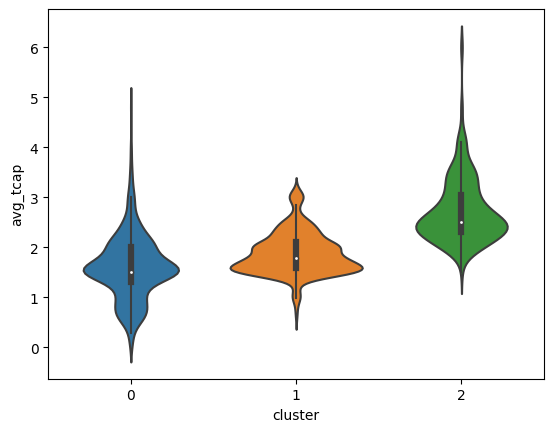

In [689]:
# show bar charts of clusters
for col in final_copy.columns:
    if col != 'cluster':
        sns.violinplot(x='cluster', y=col, data=final_copy)
        plt.show()

In [690]:
final_copy.to_csv('final_copy.csv')

In [691]:
# plot scatter plot of lat long with cluster by color on a map
fig = px.scatter_mapbox(final_copy, lat="ylat", lon="xlong", color="cluster", zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [692]:
final_copy.describe()

,Plant Id,Elec Fuel Consumption\nMMBtu,Net Generation\n(Megawatthours),Plant Code,Nameplate Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Number of Turbines,turbine_capacity (KW),hub_height (m),rotor_diameter (m),rotor_swept area (m2),max_height (m),xlong,ylat,uptime,efficiency,avg_tgen,avg_fuel,avg_tcap,cluster
count,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00,1124.00
mean,57533.07,2927454.00,331010.08,57533.07,112.02,111.40,111.47,57.22,2005.95,81.21,94.52,7381.93,128.49,-98.46,39.81,2748.32,0.11,5569.67,49258.18,1.99,0.90
std,7499.89,3000618.80,339283.04,7499.89,102.36,101.91,101.93,53.36,690.12,10.66,21.34,3170.03,19.94,14.10,5.45,927.21,0.00,2815.53,24900.55,0.70,0.74
min,90.00,478.00,54.00,90.00,1.00,0.40,0.50,1.00,150.00,28.59,19.59,425.36,41.53,-165.43,18.97,13.73,0.11,1.35,11.93,0.10,0.00
25%,56803.00,512579.75,57958.00,56803.00,23.00,22.73,22.73,12.75,1500.00,80.00,82.00,5281.02,121.00,-103.13,35.46,2125.45,0.11,3650.57,32285.65,1.50,0.00
50%,57768.00,2132911.50,241170.50,57768.00,99.00,98.95,98.95,48.00,2000.00,80.00,92.49,6720.06,126.50,-98.33,41.11,2763.77,0.11,5267.77,46588.13,2.00,1.00
75%,59969.00,4461366.00,504451.25,59969.00,174.85,174.65,174.85,87.00,2305.36,85.00,110.00,9503.32,139.90,-92.72,43.55,3486.22,0.11,7304.81,64603.76,2.30,1.00
max,64623.00,20464778.00,2313973.00,64623.00,735.50,735.50,735.50,426.00,6000.00,130.00,155.00,18869.19,198.10,-67.81,66.84,5750.48,0.11,24791.50,219256.50,6.00,2.00
